In [2]:
# code based on the following:
# tutorial: https://schmit.github.io/jax/2021/06/20/jax-language-model-rnn.html
# code: https://colab.research.google.com/drive/1Qw7zilRZVnVE4PMuKEGHrKBGaaSB3NWG#scrollTo=bI885lfVmKab

# things to do: check variation in duration to on cue

import jax
import jax.numpy as jnp
import flax.linen as jnn 
import optax
import numpy as np 
from scipy import io
from scipy.ndimage import gaussian_filter1d
from scipy.signal import decimate
import time
from flax.training import train_state, checkpoints
from flax import serialization
import pickle

##################

emg = io.loadmat("time_normalized_EMG_pre_RNN.mat")
emg_full = emg['EMG_time_normalized']

emg = np.zeros((100,6,4))
for muscle in range(6):
    for direction in range(4):
        emg_full[:,muscle,direction] = gaussian_filter1d(emg_full[:,muscle,direction],50) # filter
        emg[:,muscle,direction] = decimate(emg_full[:,muscle,direction],14) # downsample
        emg[:,muscle,direction] -= emg[0,muscle,direction]

n_muscles = 6
n_conditions = 4
movement_delay = 50
spike_length = 100

max_hold_on_time = 100
hold_decay_time = 100
max_sequence_length = max_hold_on_time + movement_delay + spike_length
n_episodes_per_condition = 5
n_episodes = n_conditions*n_episodes_per_condition
input_dim = 5
condition_specific_input = np.linspace(1,-1,n_conditions)
batch_size = n_conditions

hold_on_time = []
hold_decay = 1/(1 + np.exp(np.linspace(-7,7,hold_decay_time)))
inputs = np.zeros((n_episodes,max_sequence_length,input_dim))
x = np.linspace(-5,5,spike_length)
EMG = np.zeros([n_episodes,max_sequence_length,n_muscles])
muscle_amplitude = np.random.rand(n_muscles,n_conditions)*0.75+0.25
for episode in range(n_episodes):
    hold_on_time.append(np.random.randint(max_hold_on_time)+1)
    hold_on = np.ones(hold_on_time[-1])
    hold_off = np.zeros(max_sequence_length-hold_decay_time-hold_on_time[-1])
    inputs[episode,:,0] = np.concatenate((hold_on,hold_decay,hold_off),0)
    condition = episode % n_conditions
    # inputs[episode,:,1] = inputs[episode,:,0]*condition_specific_input[condition]
    inputs[episode,:,condition+1] = inputs[episode,:,0] # one-hot encoding
    for muscle in range(n_muscles):
        t1 = hold_on_time[-1]+movement_delay
        t2 = spike_length
        t3 = max_hold_on_time-hold_on_time[-1]
        EMG[episode,0:t1,muscle] = np.NaN
        EMG[episode,(t1):(t1+t2),muscle] = emg[:,muscle,condition]
        EMG[episode,(t1+t2):(t1+t2+t3),muscle] = np.NaN

data = [jnp.array(inputs),jnp.array(EMG)]

##################

def keyGen(seed):
    key1 = jax.random.PRNGKey(seed)
    while True:
        key1, key2 = jax.random.split(key1)
        yield key2

class RNN_jax(jnn.Module):
    hidden_dim: int

    @jnn.compact
    def __call__(self, h, input):
        h, output = jnn.GRUCell()(h, input)
        output = jnn.Dense(6)(output) # linear layer from output.shape units to 6 units
        return h, output

    def init_state(self):
        return jnp.zeros(self.hidden_dim)

def rnn_scan(params, model, state, inputs):
    final_state, Y_hat = jax.lax.scan(lambda state, x: model.apply(params, state, x), state, inputs)
    return final_state, Y_hat

def mse_loss(Y_hat, Yj):
    # compute the loss for a single example
    # use vmap (below) to vectorize
    error = Y_hat-Yj
    error = jnp.nan_to_num(error)
    L = jnp.linalg.norm(error)
    return L

def rnn_loss(params, model, state, inputs, targets):
    # use lax.scan to efficiently generate a loop over the inputs
    # this function returns the final state, and predictions (Y_hat) for every step
    # note: scan input array needs have shape [length, 1]
    final_state, Y_hat = rnn_scan(params, model, state, inputs)
    loss = jnp.mean(jax.vmap(mse_loss)(Y_hat, targets))
    return loss, final_state

# we want both the loss and gradient, we set has_aux because rnn_loss also return final state
# use static_argnums=1 to indicate that the model is static 
# a different model input will require recomplication
# finally, we jit the function to improve runtime
rnn_loss_grad = jax.jit(jax.value_and_grad(rnn_loss, has_aux=True), static_argnums=1)

def batch_step(model, params, optimizer, tx, state, inputs, targets):
#     (loss, state), grad = rnn_loss_grad(optimizer.target, model, state, inputs, targets)
#     new_optimizer = optimizer.apply_gradient(grad)
    (loss, state), grad = rnn_loss_grad(params, model, state, inputs, targets)
    updates, new_optimizer = tx.update(grad, optimizer, params)
    params = optax.apply_updates(params, updates)
    return params, new_optimizer, loss, state

def epoch_step(model, params, optimizer, tx, data, batch_size):
    state = model.init_state()
    total_loss = 0
    for i in range(data[0].shape[0]):
        inputs = data[0][i,:,:] # timestep x input_dim
        targets = data[1][i,:,:] # timestep x output_dim
        params, optimizer, loss, state = batch_step(model, params, optimizer, tx, state, inputs, targets)
    total_loss += loss
    return params, optimizer, total_loss / (i+1)

def train(data, 
          model, 
          params, 
          n_epochs,
          learning_rate=1e-3,
          weight_decay=1e-6,
          batch_size=64,
          print_every=1):

    tx = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
    optimizer = tx.init(params)
    
    losses = []
    for epoch in range(n_epochs):
        epoch_start = time.time()
        params, optimizer, avg_loss = epoch_step(model, params, optimizer, tx, data, batch_size)
        losses.append(avg_loss)
        if not epoch % print_every:
            print(f'Epoch: {epoch:3d}, loss: {avg_loss:.3f}, epoch time: {time.time() - epoch_start:.2f}')
    
#     # save a checkpoint of the model
#     state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
#     CKPT_DIR = "/Users/James/Dropbox/James MacBook/MyoSuite/Guillaume/JaxTutorial/saved_models/"
#     checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epoch)

    # save the model parameters
    bytes_output = serialization.to_bytes(params)
    filename = "GRU_muscles.pickle"
    with open(filename, 'wb') as handle:
        pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return params, optimizer, losses

def evaluate(data, model, params):
    state = model.init_state()
    predictions = []
    true_values = []
    for i in range(data[0].shape[0]):
        inputs = data[0][i,:,:] # timestep x input_dim
        targets = data[1][i,:,:] # timestep x output_dim
        final_state, Yhat = rnn_scan(params, model, state, inputs)
        predictions.append(Yhat)
        true_values.append(targets)
    return predictions, true_values

# initialize the model
key = keyGen(1)
hidden_dim = 200
model = RNN_jax(hidden_dim)
initial_params = model.init(next(key), model.init_state(), inputs[0,0,:])

In [ ]:
# train the model
n_epochs = 25
optimized_params, optimizer, losses = train(data, model, initial_params, n_epochs)

In [3]:
# load the model model (if training cell skipped)
filename = "GRU_muscles.pickle"
with open(filename, 'rb') as handle:
    optimized_params = pickle.load(handle)

In [4]:
# run the model with optimized parameters
predictions, true_values = evaluate(data, model, optimized_params)

/Users/James/opt/anaconda3/envs/myosuite/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


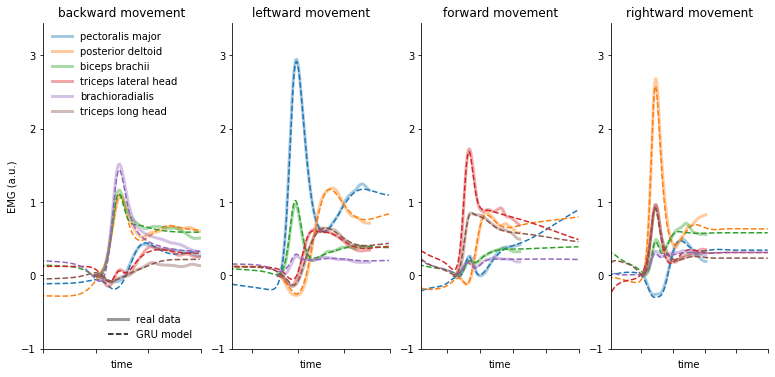

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

batch_size = len(predictions)

n_iterations = 1 # n_iterations = np.shape(true_values)[0]
batch_size = 4
fig,ax = plt.subplots(n_iterations,batch_size,figsize=(13, 6))
cmap = plt.get_cmap("tab10") # https://matplotlib.org/stable/tutorials/colors/colormaps.html
titles = ['backward movement','leftward movement','forward movement','rightward movement']
muscle_names = ['pectoralis major','posterior deltoid','biceps brachii','triceps lateral head','brachioradialis','triceps long head']
y_max = np.max((np.nanmax(true_values),np.nanmax(predictions)))+0.5
y_min = np.min((np.nanmin(true_values),np.nanmin(predictions)))-0.5
legend_elements = [Line2D([0], [0], color='k',alpha=0.4, lw=3, label='real data'),Line2D([0], [0], linestyle='--',color='k', label='GRU model')]
for example in range(batch_size):
    for muscle in range(n_muscles):
        data_starts = np.where(~np.isnan(true_values[example][:,muscle]))[0][0]
        ax[example].plot(true_values[example][:,muscle],'-',color=cmap(muscle),label=muscle_names[muscle],alpha=0.4,linewidth=3)
        ax[example].plot(predictions[example][:,muscle],'--',color=cmap(muscle))
        ax[example].set_ylim([y_min,y_max])
        ax[example].set_xlim([data_starts-50,max_sequence_length])
        ax[example].set_xticklabels(['']*10)
        ax[example].set_yticks(np.linspace(-1,3,5))
        ax[example].set_xlabel('time')
        ax[example].set_title(titles[example])
        ax[example].spines['right'].set_visible(False)
        ax[example].spines['top'].set_visible(False)
    if example == 0:
        ax[example].set_ylabel('EMG (a.u.)')
        legend1 = ax[example].legend(frameon=False,loc='upper left')
        ax[example].legend(handles=legend_elements,frameon=False,loc='lower right')
        ax[example].add_artist(legend1)
plt.ion()
plt.show()